Importamos todos los paquetes necesarios para el proyecto:

In [1]:
from search import *
from utils import *
import matplotlib.pyplot as plt
import os
import numpy as np

Matplotlib is building the font cache; this may take a moment.


Definimos la orientación de cada vector

In [15]:
# Vectores de dirección para las orientaciones
orientation_vectors = {
    0: (-1, 0),     # North
    1: (-1, 1),     # Northeast
    2: (0, 1),      # East
    3: (1, 1),      # Southeast
    4: (1, 0),      # South
    5: (1, -1),     # Southwest
    6: (0, -1),     # West
    7: (-1, -1)     # Northwest
}

## Lectura de los datos

In [7]:
class Map:
    def __init__(self, file, origin_dir = os.getcwd()):
        
        file_path = os.path.join(origin_dir, file)
        with open(file_path, 'r') as file:
            lines = file.readlines()

        dimension = list(map(int, lines[0].split()))
        self.rows, self.cols = dimension
        self.weights = np.array([list(map(int, lines[i + 1].split())) for i in range(self.rows)])
        self.start_position = tuple(map(int, lines[-2].split()))
        self.end_position = tuple(map(int, lines[-1].split()))[:2]

    def draw_initial(self):
        weights_array = np.array(self.weights)
        plt.imshow(weights_array, cmap="Blues", origin="upper")
        for i in range(self.rows):
            for j in range(self.cols):
                plt.text(j, i, str(weights_array[i, j]), color='black', fontsize=12, ha='center', va='center')

        orientation = self.start_position[2]
        if orientation == 7:
            plt.text(self.start_position[1]+0.3, self.start_position[0]+0.3, 'S', color='black', fontsize=12, ha='center', va='center', fontweight='bold')
        else:
            plt.text(self.start_position[1]-0.3, self.start_position[0]-0.3, 'S', color='black', fontsize=12, ha='center', va='center', fontweight='bold')
        plt.text(self.end_position[1]-0.3, self.end_position[0]-0.3, 'E', color='green', fontsize=12, ha='center', va='center', fontweight='bold')
        
        arrow_dy, arrow_dx = [x/2 for x in orientation_vectors[orientation]]
        plt.arrow(self.start_position[1]+arrow_dx/2, self.start_position[0]+arrow_dy/2, arrow_dx, arrow_dy, head_width=0.1, head_length=0.1, fc='black', ec='black')

        plt.axis('off')

        plt.show()
    
    def draw_solution(self, solution):
        weights_array = np.array(self.weights)
        plt.imshow(weights_array, cmap="Blues", origin="upper")
        for i in range(self.rows):
            for j in range(self.cols):
                plt.text(j, i, str(weights_array[i, j]), color='black', fontsize=12, ha='center', va='center')

        arrow_dy, arrow_dx = [x/2 for x in orientation_vectors[self.start_position[2]]]
        plt.arrow(self.start_position[1]+arrow_dx/2, self.start_position[0]+arrow_dy/2, arrow_dx, arrow_dy, head_width=0.1, head_length=0.1, fc='black', ec='black')
        
        for i in range(1, len(solution)-2):
            position = solution[i][:2]
            orientation = solution[i][2]
            arrow_dy, arrow_dx = [x/2 for x in orientation_vectors[orientation]]
            next_position = solution[i+1][:2]
            
            if next_position != position:
                plt.arrow(position[1]+arrow_dx/2, position[0]+arrow_dy/2, arrow_dx, arrow_dy, head_width=0.1, head_length=0.1, fc='red', ec='red')
            else:
                plt.arrow(position[1]+arrow_dx/2, position[0]+arrow_dy/2, arrow_dx, arrow_dy, head_width=0.1, head_length=0.1, fc='blue', ec='blue')
        
        position = solution[-2][:2]
        orientation = solution[-2][2]
        arrow_dy, arrow_dx = [x/2 for x in orientation_vectors[orientation]]
        plt.arrow(position[1]+arrow_dx/2, position[0]+arrow_dy/2, arrow_dx, arrow_dy, head_width=0.1, head_length=0.1, fc='green', ec='green')
                
        plt.axis('off')
        plt.show()

We read two example maps:

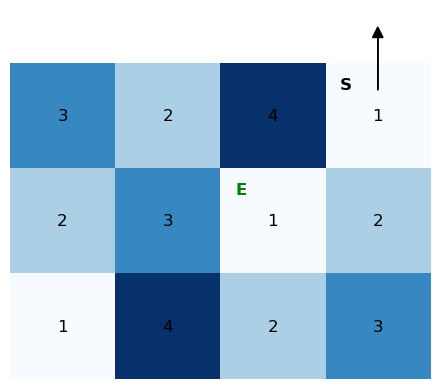

In [16]:
map1 = Map("exampleMap.txt")
map1.draw_initial()

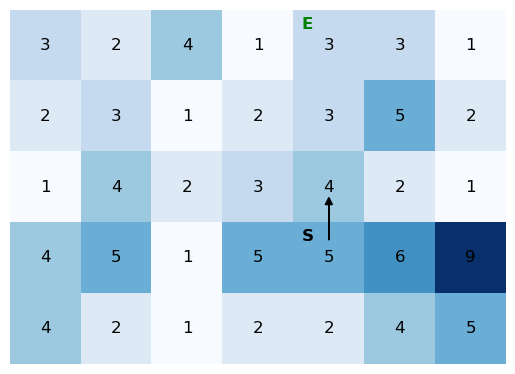

In [11]:
map2 = Map("exampleMap_2.txt")
map2.draw_initial()

In [9]:
class RobotProblem(Problem):

    def __init__(self, map):
        Problem.__init__(self, map.start_position, map.end_position)
        self.weights = map.weights
        self.dimensions = map.weights.shape

    def actions(self, state):
        actions = []
        actions.append((state[0], state[1], (state[2] - 1) % 8))
        actions.append((state[0], state[1], (state[2] + 1) % 8))
        new_position = [state[0] + orientation_vectors[state[2]][0], state[1] + orientation_vectors[state[2]][1]]
        if 0 <= new_position[0] < self.dimensions[0] and 0 <= new_position[1] < self.dimensions[1]:
            actions.append((new_position[0], new_position[1], state[2]))
        return actions
    
    def result(self, state, action):
        return action
    
    def goal_test(self, state):
        return state[:2] == self.goal[:2]
    
    def path_cost(self, cost_so_far, state1, action, state2):
        if state1[:2] == state2[:2]:
            return cost_so_far + 1
        else:
            return cost_so_far + self.weights[state2[0], state2[1]]

In [12]:
robot_problem = RobotProblem(map1)
robot_problem_2 = RobotProblem(map2)

In [13]:
def breadth_first_graph_search(problem):
    node = Node(problem.initial)
    if problem.goal_test(node.state):
        return node
    frontier = deque([node])
    explored = []
    while frontier:
        node = frontier.popleft()
        explored.append(node.state)
        for child in node.expand(problem):
            if child.state not in explored and child not in frontier:
                if problem.goal_test(child.state):
                    return child, explored, frontier
                frontier.append(child)
    return None

Coste = 4
Solución = [(0, 3, 0), (0, 3, 7), (0, 3, 6), (0, 3, 5), (1, 2, 5)]
Explorados = [(0, 3, 0), (0, 3, 7), (0, 3, 1), (0, 3, 6), (0, 3, 2), (0, 3, 5)]
Frontera final = [(0, 2, 6), (0, 3, 3), (0, 3, 4)]


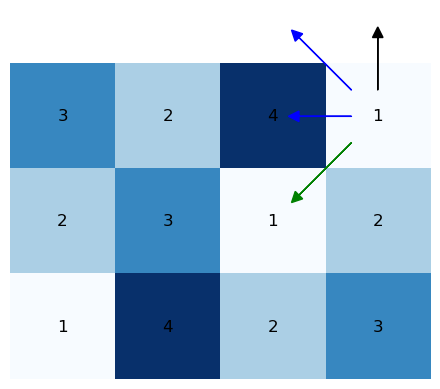

In [17]:
final_node, explored, frontier = breadth_first_graph_search(robot_problem)
cost = final_node.path_cost
frontier = [frontier[i].state for i in range(len(frontier))]
print(f'Coste = ' + str(cost))
solution = final_node.solution()
solution.insert(0, map1.start_position)
print(f'Solución = ' + str(solution))
print(f'Explorados = ' + str(explored))
print(f'Frontera final = ' + str(frontier))
map1.draw_solution(solution)

Coste = 12
Solución = [(3, 4, 6), (3, 4, 7), (3, 4, 0), (2, 4, 0), (1, 4, 0), (0, 4, 0)]
Explorados = [(3, 4, 6), (3, 4, 5), (3, 4, 7), (3, 3, 6), (3, 4, 4), (4, 3, 5), (3, 4, 0), (2, 3, 7), (3, 3, 5), (3, 3, 7), (3, 2, 6), (3, 4, 3), (4, 4, 4), (4, 3, 4), (4, 3, 6), (3, 4, 1), (2, 4, 0), (2, 3, 6), (2, 3, 0), (1, 2, 7), (3, 3, 4), (4, 2, 5), (3, 3, 0), (2, 2, 7), (3, 2, 5), (3, 2, 7), (3, 1, 6), (3, 4, 2), (4, 5, 3), (4, 4, 3), (4, 4, 5), (4, 3, 3), (4, 3, 7), (4, 2, 6), (2, 5, 1), (2, 4, 7), (2, 4, 1), (1, 4, 0)]
Frontera final = [(2, 3, 5), (2, 2, 6), (2, 3, 1), (1, 3, 0), (1, 2, 6), (1, 2, 0), (0, 1, 7), (3, 3, 3), (4, 2, 4), (3, 3, 1), (2, 2, 0), (1, 1, 7), (3, 2, 4), (4, 1, 5), (3, 2, 0), (2, 1, 7), (3, 1, 5), (3, 1, 7), (3, 0, 6), (3, 5, 2), (4, 5, 2), (4, 5, 4), (4, 4, 2), (4, 4, 6), (4, 3, 2), (4, 3, 0), (4, 2, 7), (4, 1, 6), (2, 5, 0), (2, 5, 2), (1, 6, 1), (2, 4, 6), (1, 3, 7), (2, 4, 2), (1, 5, 1), (1, 4, 7), (1, 4, 1)]


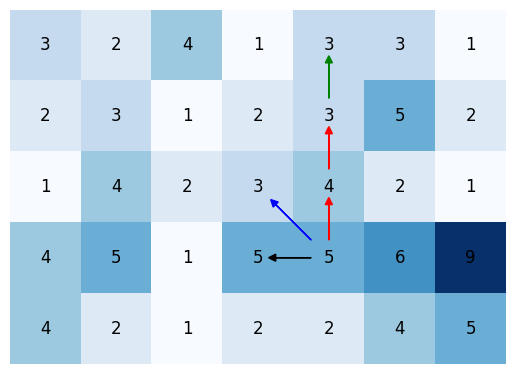

In [87]:
final_node, explored, frontier = breadth_first_graph_search(robot_problem_2)
cost = final_node.path_cost
frontier = [frontier[i].state for i in range(len(frontier))]
print(f'Coste = ' + str(cost))
solution = final_node.solution()
solution.insert(0, map2.start_position)
print(f'Solución = ' + str(solution))
print(f'Explorados = ' + str(explored))
print(f'Frontera final = ' + str(frontier))
map2.draw_solution(solution)

In [54]:
def depth_first_graph_search(problem):
    frontier = [(Node(problem.initial))]

    explored = []
    while frontier:
        node = frontier.pop()
        if problem.goal_test(node.state):
            return node, explored, frontier
        explored.append(node.state)
        frontier.extend(child for child in node.expand(problem)
                        if child.state not in explored and child not in frontier)
    return None

Coste = 36
Solución = [(0, 3, 0), (0, 3, 1), (0, 3, 2), (0, 3, 3), (0, 3, 4), (1, 3, 4), (2, 3, 4), (2, 3, 5), (2, 3, 6), (2, 2, 6), (2, 1, 6), (2, 0, 6), (2, 0, 7), (2, 0, 0), (1, 0, 0), (0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 1, 2), (0, 2, 2), (0, 2, 3), (0, 2, 4), (1, 2, 4)]
Explorados = [(0, 3, 0), (0, 3, 1), (0, 3, 2), (0, 3, 3), (0, 3, 4), (1, 3, 4), (2, 3, 4), (2, 3, 5), (2, 3, 6), (2, 2, 6), (2, 1, 6), (2, 0, 6), (2, 0, 7), (2, 0, 0), (1, 0, 0), (0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 1, 2), (0, 2, 2), (0, 2, 3), (0, 2, 4)]
Frontera final = [(0, 3, 7), (0, 3, 5), (1, 3, 3), (1, 3, 5), (2, 3, 3), (2, 3, 7), (2, 2, 5), (2, 2, 7), (2, 1, 5), (2, 1, 7), (2, 0, 5), (2, 0, 1), (1, 0, 7), (1, 0, 1), (0, 0, 7), (0, 0, 3), (0, 1, 1), (0, 1, 3), (0, 2, 1), (0, 2, 5)]


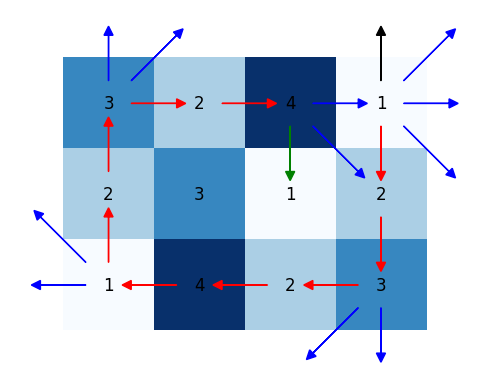

In [88]:
final_node, explored, frontier = depth_first_graph_search(robot_problem)
cost = final_node.path_cost
frontier = [frontier[i].state for i in range(len(frontier))]
print(f'Coste = ' + str(cost))
solution = final_node.solution()
solution.insert(0, map1.start_position)
print(f'Solución = ' + str(solution))
print(f'Explorados = ' + str(explored))
print(f'Frontera final = ' + str(frontier))
map1.draw_solution(solution)

Coste = 35
Solución = [(3, 4, 6), (3, 3, 6), (3, 2, 6), (3, 1, 6), (3, 0, 6), (3, 0, 7), (3, 0, 0), (2, 0, 0), (1, 0, 0), (0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 1, 2), (0, 2, 2), (0, 3, 2), (0, 4, 2)]
Explorados = [(3, 4, 6), (3, 3, 6), (3, 2, 6), (3, 1, 6), (3, 0, 6), (3, 0, 7), (3, 0, 0), (2, 0, 0), (1, 0, 0), (0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 1, 2), (0, 2, 2), (0, 3, 2)]
Frontera final = [(3, 4, 5), (3, 4, 7), (3, 3, 5), (3, 3, 7), (3, 2, 5), (3, 2, 7), (3, 1, 5), (3, 1, 7), (3, 0, 5), (3, 0, 1), (2, 0, 7), (2, 0, 1), (1, 0, 7), (1, 0, 1), (0, 0, 7), (0, 0, 3), (0, 1, 1), (0, 1, 3), (0, 2, 1), (0, 2, 3), (0, 3, 1), (0, 3, 3)]


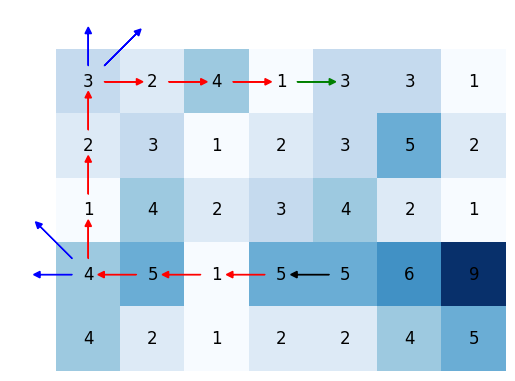

In [98]:
final_node, explored, frontier = depth_first_graph_search(robot_problem_2)
cost = final_node.path_cost
frontier = [frontier[i].state for i in range(len(frontier))]
print(f'Coste = ' + str(cost))
solution = final_node.solution()
solution.insert(0, map2.start_position)
print(f'Solución = ' + str(solution))
print(f'Explorados = ' + str(explored))
print(f'Frontera final = ' + str(frontier))
map2.draw_solution(solution)

In [83]:
def best_first_graph_search(problem, f, display=False):
    f = memoize(f, 'f')
    node = Node(problem.initial)
    frontier = PriorityQueue('min', f)
    frontier.append(node)
    explored = []
    while frontier:
        node = frontier.pop()
        if problem.goal_test(node.state):
            if display:
                print(len(explored), "paths have been expanded and", len(frontier), "paths remain in the frontier")
            return node, explored, frontier
        explored.append(node.state)
        for child in node.expand(problem):
            if child.state not in explored and child not in frontier:
                frontier.append(child)
            elif child in frontier:
                if f(child) < frontier[child]:
                    del frontier[child]
                    frontier.append(child)
    return None

In [84]:
def astar_search(problem, h=None, display=False):
    h = memoize(h or problem.h, 'h')
    return best_first_graph_search(problem, lambda n: n.path_cost + h(n), display)

In [85]:
def chebyshev_distance(start, goal):
    x1, y1 = start
    x2, y2 = goal
    
    return max(abs(x2 - x1), abs(y2 - y1))

In [92]:
class RobotProblem_Chebyshev(RobotProblem):

    def __init__(self, map):
        RobotProblem.__init__(self, map)
        
    def h(self, node):
        return chebyshev_distance(node.state[:2], self.goal[:2])

In [94]:
robot_problem_chebyshev = RobotProblem_Chebyshev(map1)
robot_problem_2_chebyshev = RobotProblem_Chebyshev(map2)

Coste = 4
Solución = [(0, 3, 0), (0, 3, 7), (0, 3, 6), (0, 3, 5), (1, 2, 5)]
Explorados = [(0, 3, 0), (0, 3, 1), (0, 3, 7), (0, 3, 2), (0, 3, 6), (0, 3, 3), (0, 3, 5)]
Frontera final = [(0, 3, 4), (0, 2, 6)]


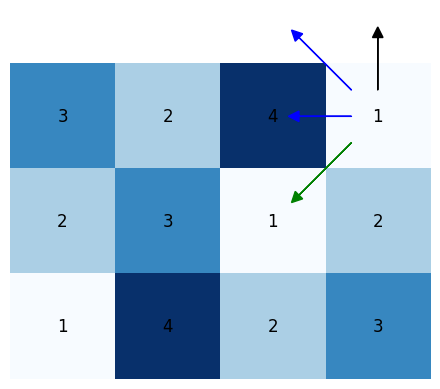

In [99]:
final_node, explored, frontier = astar_search(robot_problem_chebyshev)
cost = final_node.path_cost
frontier = [node.state for _, node in frontier.heap]
print(f'Coste = ' + str(cost))
solution = final_node.solution()
solution.insert(0, map1.start_position)
print(f'Solución = ' + str(solution))
print(f'Explorados = ' + str(explored))
print(f'Frontera final = ' + str(frontier))
map1.draw_solution(solution)

Coste = 11
Solución = [(3, 4, 6), (3, 4, 7), (2, 3, 7), (2, 3, 0), (1, 3, 0), (1, 3, 1), (0, 4, 1)]
Explorados = [(3, 4, 6), (3, 4, 5), (3, 4, 7), (3, 4, 0), (3, 4, 4), (2, 3, 7), (3, 4, 1), (3, 4, 3), (1, 2, 7), (2, 3, 0), (2, 3, 6), (2, 5, 1), (3, 4, 2), (4, 3, 5), (1, 2, 0), (1, 2, 6), (1, 3, 0), (2, 3, 1), (2, 3, 5), (2, 4, 0), (2, 5, 0), (2, 5, 2), (3, 3, 6), (4, 3, 4), (4, 3, 6), (4, 4, 4), (0, 3, 0), (1, 2, 1), (0, 3, 1), (1, 2, 5), (1, 3, 1), (1, 3, 7), (1, 6, 1), (2, 2, 6), (2, 3, 2), (2, 3, 4), (2, 4, 1), (2, 4, 7), (2, 5, 3), (2, 5, 7), (2, 6, 2), (3, 2, 6), (3, 3, 5), (3, 3, 7), (4, 2, 6), (4, 3, 3), (4, 3, 7), (3, 2, 7), (4, 4, 3), (4, 4, 5), (0, 1, 7), (0, 3, 2), (0, 3, 7), (1, 2, 2), (1, 2, 4), (1, 3, 2), (1, 3, 6), (1, 4, 0), (1, 4, 1), (1, 6, 0), (1, 6, 2), (2, 2, 5), (2, 2, 7), (2, 3, 3), (2, 4, 2), (2, 4, 6), (2, 5, 4), (2, 5, 6), (2, 6, 1), (2, 6, 3), (3, 2, 0), (3, 2, 5), (3, 3, 0), (3, 3, 4), (4, 2, 5), (4, 2, 7), (4, 3, 0), (4, 3, 2), (4, 4, 2), (4, 4, 6), (0, 1,

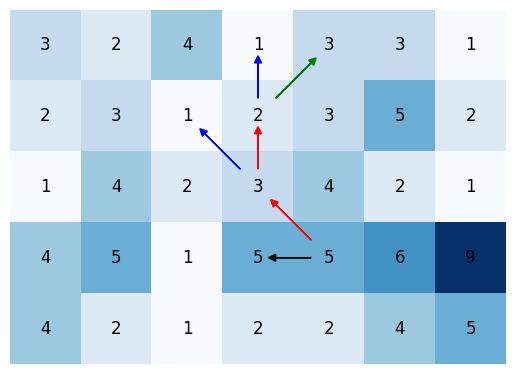

In [100]:
final_node, explored, frontier = astar_search(robot_problem_2_chebyshev)
cost = final_node.path_cost
frontier = [node.state for _, node in frontier.heap]
print(f'Coste = ' + str(cost))
solution = final_node.solution()
solution.insert(0, map2.start_position)
print(f'Solución = ' + str(solution))
print(f'Explorados = ' + str(explored))
print(f'Frontera final = ' + str(frontier))
map2.draw_solution(solution)

In [101]:
def euclidean_scaled_distance(start, goal):
    
    x1, y1 = start
    x2, y2 = goal
    
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)*np.sqrt(2)/2

In [103]:
class RobotProblem_Euclidean(RobotProblem):

    def __init__(self, map):
        RobotProblem.__init__(self, map)
        
    def h(self, node):
        return euclidean_scaled_distance(node.state[:2], self.goal[:2])

In [104]:
robot_problem_euclidean = RobotProblem_Euclidean(map1)
robot_problem_2_euclidean = RobotProblem_Euclidean(map2)

Coste = 4
Solución = [(0, 3, 0), (0, 3, 7), (0, 3, 6), (0, 3, 5), (1, 2, 5)]
Explorados = [(0, 3, 0), (0, 3, 1), (0, 3, 7), (0, 3, 2), (0, 3, 6), (0, 3, 3), (0, 3, 5)]
Frontera final = [(0, 3, 4), (0, 2, 6)]


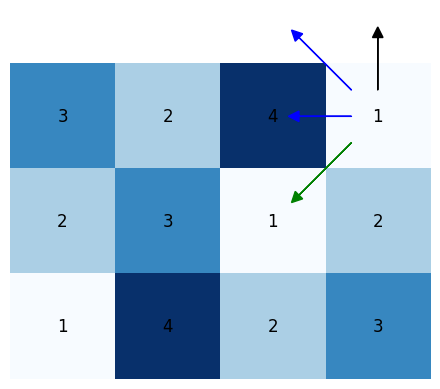

In [105]:
final_node, explored, frontier = astar_search(robot_problem_euclidean)
cost = final_node.path_cost
frontier = [node.state for _, node in frontier.heap]
print(f'Coste = ' + str(cost))
solution = final_node.solution()
solution.insert(0, map1.start_position)
print(f'Solución = ' + str(solution))
print(f'Explorados = ' + str(explored))
print(f'Frontera final = ' + str(frontier))
map1.draw_solution(solution)

Coste = 11
Solución = [(3, 4, 6), (3, 4, 7), (2, 3, 7), (2, 3, 0), (1, 3, 0), (1, 3, 1), (0, 4, 1)]
Explorados = [(3, 4, 6), (3, 4, 5), (3, 4, 7), (3, 4, 0), (3, 4, 4), (3, 4, 1), (3, 4, 3), (2, 3, 7), (4, 3, 5), (3, 4, 2), (1, 2, 7), (2, 3, 0), (2, 3, 6), (2, 5, 1), (4, 4, 4), (4, 3, 4), (4, 3, 6), (3, 3, 6), (2, 4, 0), (1, 2, 0), (1, 2, 6), (2, 3, 1), (2, 3, 5), (2, 5, 0), (2, 5, 2), (4, 4, 3), (4, 4, 5), (4, 3, 3), (4, 3, 7), (1, 3, 0), (4, 2, 6), (3, 3, 5), (3, 3, 7), (2, 4, 1), (2, 4, 7), (3, 2, 6), (3, 2, 7), (1, 2, 1), (1, 2, 5), (1, 6, 1), (2, 3, 2), (2, 3, 4), (2, 5, 3), (2, 5, 7), (0, 3, 0), (0, 3, 1), (4, 4, 2), (4, 4, 6), (4, 3, 0), (4, 3, 2), (1, 3, 1), (1, 3, 7), (2, 2, 6), (2, 6, 2), (0, 1, 7), (4, 2, 5), (4, 2, 7), (3, 3, 0), (3, 3, 4), (2, 4, 2), (2, 4, 6), (3, 2, 0), (3, 2, 5), (1, 2, 2), (1, 2, 4), (1, 6, 0), (1, 6, 2), (2, 3, 3), (2, 5, 4), (2, 5, 6), (0, 3, 2), (0, 3, 7), (1, 4, 0), (1, 4, 1), (4, 4, 1), (4, 4, 7), (4, 3, 1), (4, 5, 3), (1, 3, 2), (1, 3, 6), (2, 2,

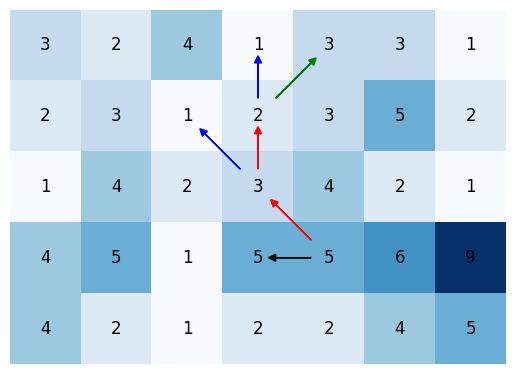

In [106]:
final_node, explored, frontier = astar_search(robot_problem_2_euclidean)
cost = final_node.path_cost
frontier = [node.state for _, node in frontier.heap]
print(f'Coste = ' + str(cost))
solution = final_node.solution()
solution.insert(0, map2.start_position)
print(f'Solución = ' + str(solution))
print(f'Explorados = ' + str(explored))
print(f'Frontera final = ' + str(frontier))
map2.draw_solution(solution)